In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import networkx as nx
from datetime import datetime
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import folium
from datetime import datetime
import matplotlib.dates as mdates
from pyvis.network import Network



In [2]:
data = pd.read_csv("CLIWOC15.csv")




/var/folders/gx/00rhw4l96ws8t6wj4d0r_m2c0000gn/T/ipykernel_52876/3583520192.py:1: DtypeWarning: Columns (5,6,7,8,11,13,18,19,23,24,25,26,28,29,30,34,35,38,43,44,46,73,77,81,82,84,85,87,88,94,96,97,98,99,111,114,116,119,120,122,124,125,127,129,131,133,135,137,140) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("CLIWOC15.csv")


In [3]:
data.head()
# Assuming you have a DataFrame called df
unique_country = data['InstLand'].unique()

print("Number of unique values in 'InstLand':", unique_country)

Number of unique values in 'InstLand': ['Spain' 'United Kingdom' 'France' 'Nederland' 'Sweden']


In [4]:
unique_year = data['Year'].unique()
unique_year.sort()
print(unique_year)

[1662 1663 1675 1676 1677 1699 1742 1745 1746 1747 1748 1749 1750 1751
 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765
 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779
 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793
 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807
 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821
 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835
 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849
 1850 1851 1852 1853 1854 1855]


In [5]:

# Filter the data to include only the years 1770 to 1790
filtered_data = data[(data['Year'] >= 1770) & (data['Year'] <= 1779)]

# Create a new dataframe from the filtered data
new_dataframe = pd.DataFrame(filtered_data)

# Display the shape of the new dataframe
print('New dataframe shape:', new_dataframe.shape)


New dataframe shape: (46237, 141)


In [6]:
def columns_with_many_nans(df, threshold):
    """
    Returns a list of column names in the DataFrame that have more than the specified threshold of NaN values.
    """
    nan_count = df.isnull().sum()
    columns_with_excess_nans = nan_count[nan_count > threshold].index.tolist()
    return columns_with_excess_nans

threshold_start=256000
columns_with_excess_nan_values = columns_with_many_nans(new_dataframe, threshold_start)


# Deleting the columns with excess NaN values
df_cleaned_empty = new_dataframe.drop(columns_with_excess_nan_values, axis=1)
print(df_cleaned_empty.shape)

(46237, 141)


In [7]:
# Assuming you have a DataFrame called df
unique_country = df_cleaned_empty['InstLand'].unique()

print("Number of unique values in 'InstLand':", unique_country)

Number of unique values in 'InstLand': ['Spain' 'United Kingdom' 'France' 'Nederland']


In [8]:
dataframes_dict = {}

for country in unique_country:
    dataframes_dict[country.strip()] = df_cleaned_empty[df_cleaned_empty['InstLand'] == country]
    
# Create seperate dataframes
Spain = dataframes_dict['Spain']
print('Spain:',Spain.shape)

UnitedKingdom = dataframes_dict['United Kingdom']
print('United Kingdom:',UnitedKingdom.shape)

France = dataframes_dict['France']
print('France:',France.shape)

Nederland = dataframes_dict['Nederland']
print('Nederland:',Nederland.shape)

France.to_excel("France.xlsx")

Spain: (26785, 141)
United Kingdom: (11863, 141)
France: (1707, 141)
Nederland: (5882, 141)


###  France Voyages

In [9]:
# Creating a new column 'Date' in the 'France' dataframe by concatenating the 'Day', 'Month', and 'Year' columns
# First, let's check if these columns exist in the dataframe
if {'Day', 'Month', 'Year'}.issubset(France.columns):
    # The columns exist, so we proceed to create the 'Date' column
    # We convert each column to string type to be able to concatenate them and then combine with a dash "-"
    France['Date'] = France['Year'].astype(str) + "-" + France['Month'].astype(str) + "-" + France['Day'].astype(str)
    # Showing the dataframe to confirm the new 'Date' column
    result = France[['Day', 'Month', 'Year', 'Date']].head()  # Displaying the first few rows to verify
else:
    result = "One or more of the 'Day', 'Month', or 'Year' columns do not exist in the 'France' dataframe."

result

/var/folders/gx/00rhw4l96ws8t6wj4d0r_m2c0000gn/T/ipykernel_52876/2861059910.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  France['Date'] = France['Year'].astype(str) + "-" + France['Month'].astype(str) + "-" + France['Day'].astype(str)


,Day,Month,Year,Date
61794,7,8,1776,1776-8-7
61795,8,8,1776,1776-8-8
61796,9,8,1776,1776-8-9
61797,10,8,1776,1776-8-10
61798,11,8,1776,1776-8-11


In [10]:
# To find the unique 'VoyageFrom' and 'VoyageTo' pairings for each 'VoyageIni',
# we will first check if there are multiple pairings for any 'VoyageIni'.
# If there are multiple pairings, we will list them.

# Check if the columns 'VoyageIni', 'VoyageFrom', and 'VoyageTo' are in the dataframe
if {'VoyageIni', 'VoyageFrom', 'VoyageTo','ShipName'}.issubset(France.columns):
    # Create a DataFrame to hold the unique pairs
    France_unique_pairs_df = France.drop_duplicates(subset=['VoyageIni', 'VoyageFrom', 'VoyageTo','ShipName'])

    # Now, we will filter out only those 'VoyageIni' that have a single 'VoyageFrom' and 'VoyageTo' pairing
    France_unique_voyage_pairs = France_unique_pairs_df.groupby('VoyageIni').filter(lambda x: len(x) == 1)

    # Display the unique 'VoyageFrom' and 'VoyageTo' pairings for each 'VoyageIni'
    France_unique_pairings = France_unique_voyage_pairs[['VoyageIni', 'VoyageFrom', 'VoyageTo','ShipName']].dropna()
else:
    France_unique_pairings = "The columns 'VoyageIni', 'VoyageFrom', or 'VoyageTo' do not exist in the dataset."

France_unique_pairings



,VoyageIni,VoyageFrom,VoyageTo,ShipName
61868,17750605.0,Brest,Fort Royal,Amphitrite
62040,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule
62072,17710620.0,Brest,Cadix,La Belle Poule
62116,17710807.0,Cadix,Malagua,La Belle Poule
62120,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule
62140,17710923.0,Cadix,Brest,La Belle Poule
64471,17751121.0,Brest,Martinique,La Tourterelle
64491,17760401.0,Martinique,Brest,La Tourterelle
65098,17751001.0,Port Louis,Martinique,Le Oiseau
65109,17760310.0,Guadeloupe,Brest,Le Oiseau


In [11]:
# To include the smallest and largest dates associated with each 'VoyageIni',
# we will first ensure that the 'Date' column is in a proper date format.
# Then we will group the data by 'VoyageIni' and aggregate to find the min and max dates.

# Check if the 'Date' column is in the right format and if not, convert it to datetime
if 'Date' in France.columns:
    # Convert 'Date' column to datetime format
    France['Date'] = pd.to_datetime(France['Date'], errors='coerce')
    
    # Group by 'VoyageIni' and find the smallest (min) and largest (max) dates
    France_date_aggregations = France.groupby('VoyageIni')['Date'].agg(MinDate='min', MaxDate='max')
    
    # Join the min and max date columns to the unique_pairings_with_ship_name dataframe
    France_unique_pairings = France_unique_pairings.join(France_date_aggregations, on='VoyageIni')
else:
    France_unique_pairings = "The 'Date' column does not exist or is not in the right format."

France_unique_pairings


/var/folders/gx/00rhw4l96ws8t6wj4d0r_m2c0000gn/T/ipykernel_52876/1331504398.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  France['Date'] = pd.to_datetime(France['Date'], errors='coerce')


,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate
61868,17750605.0,Brest,Fort Royal,Amphitrite,1775-06-05,1775-07-06
62040,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-05-04,1771-06-15
62072,17710620.0,Brest,Cadix,La Belle Poule,1771-06-20,1771-07-25
62116,17710807.0,Cadix,Malagua,La Belle Poule,1771-08-07,1771-08-10
62120,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-09-15,1771-09-20
62140,17710923.0,Cadix,Brest,La Belle Poule,1771-09-23,1771-10-10
64471,17751121.0,Brest,Martinique,La Tourterelle,1775-11-21,1775-12-28
64491,17760401.0,Martinique,Brest,La Tourterelle,1776-04-01,1776-05-03
65098,17751001.0,Port Louis,Martinique,Le Oiseau,1775-10-01,1775-11-19
65109,17760310.0,Guadeloupe,Brest,Le Oiseau,1776-03-10,1776-04-14


In [12]:
# To find the duration, we will subtract the 'min' date from the 'max' date for each 'VoyageIni'

# First, ensure the 'min' and 'max' columns are in the datetime format
France_unique_pairings['MinDate'] = pd.to_datetime(France_unique_pairings['MinDate'], errors='coerce')
France_unique_pairings['MaxDate'] = pd.to_datetime(France_unique_pairings['MaxDate'], errors='coerce')

# Calculating the duration as the difference between 'max' and 'min' dates
France_unique_pairings['Duration'] = France_unique_pairings['MaxDate'] - France_unique_pairings['MinDate']

# Show the dataframe with the new 'Duration' column
France_unique_pairings[['VoyageIni', 'VoyageFrom', 'VoyageTo', 'ShipName', 'MinDate', 'MaxDate', 'Duration']]

,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration
61868,17750605.0,Brest,Fort Royal,Amphitrite,1775-06-05,1775-07-06,31 days
62040,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-05-04,1771-06-15,42 days
62072,17710620.0,Brest,Cadix,La Belle Poule,1771-06-20,1771-07-25,35 days
62116,17710807.0,Cadix,Malagua,La Belle Poule,1771-08-07,1771-08-10,3 days
62120,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-09-15,1771-09-20,5 days
62140,17710923.0,Cadix,Brest,La Belle Poule,1771-09-23,1771-10-10,17 days
64471,17751121.0,Brest,Martinique,La Tourterelle,1775-11-21,1775-12-28,37 days
64491,17760401.0,Martinique,Brest,La Tourterelle,1776-04-01,1776-05-03,32 days
65098,17751001.0,Port Louis,Martinique,Le Oiseau,1775-10-01,1775-11-19,49 days
65109,17760310.0,Guadeloupe,Brest,Le Oiseau,1776-03-10,1776-04-14,35 days


In [13]:
France_unique_pairings['HomeCountry'] = 'France'

In [14]:
# Sort the dataframe first by 'ShipName' and then by 'min' date in ascending order to see the voyages in sequence
France_sorted_ship_voyages = France_unique_pairings.sort_values(by=['ShipName', 'MinDate'])

# Display the sorted dataframe to confirm the sequence of voyages for each ship
France_sorted_ship_voyages.reset_index()[['VoyageIni', 'ShipName', 'VoyageFrom', 'VoyageTo', 'MinDate', 'MaxDate']]

France_sorted_ship_voyages['FormattedMin'] = France_sorted_ship_voyages['MinDate'].dt.strftime('%B %d, %Y')
France_sorted_ship_voyages['FormattedMax'] = France_sorted_ship_voyages['MaxDate'].dt.strftime('%B %d, %Y')
France_sorted_ship_voyages

,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration,HomeCountry,FormattedMin,FormattedMax
61868,17750605.0,Brest,Fort Royal,Amphitrite,1775-06-05,1775-07-06,31 days,France,"June 05, 1775","July 06, 1775"
67074,17721225.0,Brest,Cap,L'actionnaire,1772-12-25,1773-01-22,28 days,France,"December 25, 1772","January 22, 1773"
67113,17730428.0,Cap,Brest,L'actionnaire,1773-04-28,1773-06-05,38 days,France,"April 28, 1773","June 05, 1773"
267934,17770409.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-04-09,1777-06-22,74 days,France,"April 09, 1777","June 22, 1777"
267988,17771004.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-10-04,1777-10-27,23 days,France,"October 04, 1777","October 27, 1777"
62040,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-05-04,1771-06-15,42 days,France,"May 04, 1771","June 15, 1771"
62072,17710620.0,Brest,Cadix,La Belle Poule,1771-06-20,1771-07-25,35 days,France,"June 20, 1771","July 25, 1771"
62116,17710807.0,Cadix,Malagua,La Belle Poule,1771-08-07,1771-08-10,3 days,France,"August 07, 1771","August 10, 1771"
62120,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-09-15,1771-09-20,5 days,France,"September 15, 1771","September 20, 1771"
62140,17710923.0,Cadix,Brest,La Belle Poule,1771-09-23,1771-10-10,17 days,France,"September 23, 1771","October 10, 1771"


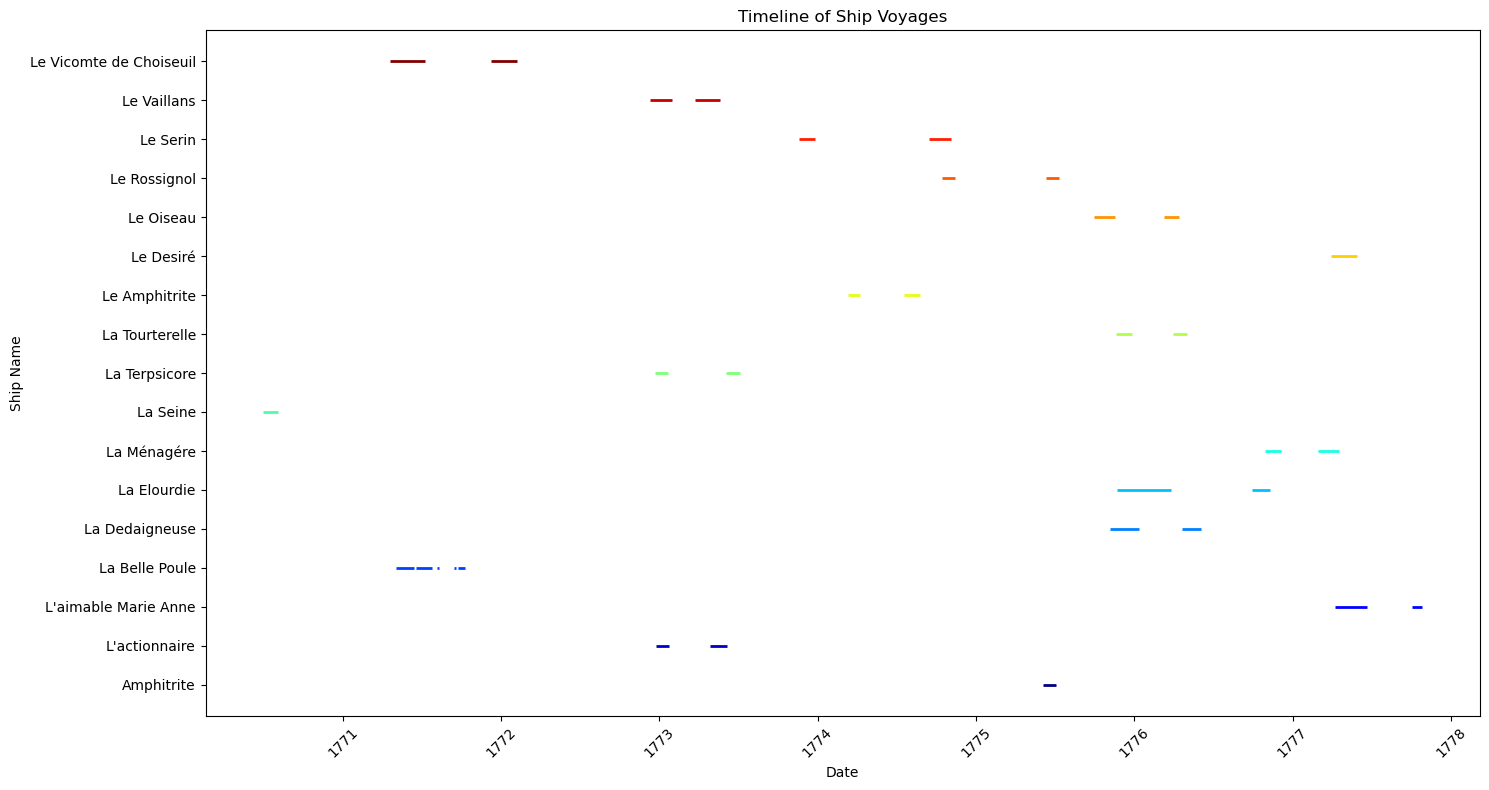

In [15]:
# Preparing the data for visualization
# We'll create a list of tuples with (ShipName, min_date, max_date) for each voyage
voyage_data = list(
    France_sorted_ship_voyages[['ShipName', 'MinDate', 'MaxDate']].itertuples(index=False, name=None)
)

# Setting up the plot
plt.figure(figsize=(15, 8))
ax = plt.subplot()

# Each ship will have a unique color
colors = plt.cm.jet(np.linspace(0, 1, len(France_sorted_ship_voyages['ShipName'].unique())))

# Creating a color dictionary for ships
color_dict = dict(zip(France_sorted_ship_voyages['ShipName'].unique(), colors))

# Plotting each voyage as a line from min_date to max_date for the ship
for ship, group in France_sorted_ship_voyages.groupby('ShipName'):
    for _, row in group.iterrows():
        plt.hlines(y=ship, xmin=row['MinDate'], xmax=row['MaxDate'], colors=color_dict[ship], lw=2)

# Formatting the dates on the x-axis to make them more readable
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Labels and title
plt.xlabel('Date')
plt.ylabel('Ship Name')
plt.title('Timeline of Ship Voyages')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [16]:
# Ensure the dataframe is sorted by 'ShipName' and start date
sorted_ship_voyages = France_sorted_ship_voyages.sort_values(by=['ShipName', 'MinDate'])

# Shift the 'VoyageTo' column within each group of 'ShipName'
sorted_ship_voyages['NextVoyageFrom'] = sorted_ship_voyages.groupby('ShipName')['VoyageTo'].shift(-1)

# Compare the shifted 'VoyageTo' with the 'VoyageFrom' of the next voyage
sorted_ship_voyages['SameStartAsLastEnd'] = (
    sorted_ship_voyages['NextVoyageFrom'] == sorted_ship_voyages['VoyageFrom']
)

# Filter the dataframe to show only the rows where the start of a voyage matches the end of the previous voyage
same_start_end_voyages = sorted_ship_voyages[sorted_ship_voyages['SameStartAsLastEnd']]

# This will give you the rows where a ship starts a new voyage from where the last one ended
same_start_end_voyages[['ShipName', 'VoyageFrom', 'VoyageTo', 'MinDate', 'MaxDate', 'NextVoyageFrom']]

,ShipName,VoyageFrom,VoyageTo,MinDate,MaxDate,NextVoyageFrom
67074,L'actionnaire,Brest,Cap,1772-12-25,1773-01-22,Brest
65847,La Dedaigneuse,Brest,St Domingue,1775-11-07,1776-01-13,Brest
66067,La Elourdie,St. Nazaire,St Domingue,1775-11-23,1776-03-27,St. Nazaire
66515,La Ménagére,Rochefort,Martinique,1776-10-30,1776-12-05,Rochefort
66861,La Terpsicore,Isle d'Aix,Fort Royal,1772-12-21,1773-01-21,Isle d'Aix
64471,La Tourterelle,Brest,Martinique,1775-11-21,1775-12-28,Brest
67151,Le Amphitrite,Brest,St Domingue,1774-03-11,1774-04-09,Brest
67826,Le Serin,Brest,St Domingue,1773-11-19,1773-12-26,Brest
67923,Le Vaillans,Brest,St Domingue,1772-12-10,1773-01-29,Brest


In [17]:
# Ensure the dataframe is sorted by 'ShipName' and start date
sorted_ship_voyages = France_sorted_ship_voyages.sort_values(by=['ShipName', 'MinDate'])

# Shift the 'VoyageTo' column within each group of 'ShipName'
sorted_ship_voyages['NextVoyageFrom'] = sorted_ship_voyages.groupby('ShipName')['VoyageTo'].shift(-1)

# Compare the shifted 'VoyageTo' with the 'VoyageFrom' of the next voyage
sorted_ship_voyages['SameStartAsLastEnd'] = (
    sorted_ship_voyages['NextVoyageFrom'] == sorted_ship_voyages['VoyageFrom']
)

# Filter the dataframe to show only the rows where the start of a voyage matches the end of the previous voyage
same_start_end_voyages = sorted_ship_voyages[sorted_ship_voyages['SameStartAsLastEnd']]

# This will give you the rows where a ship starts a new voyage from where the last one ended
same_start_end_voyages[['ShipName', 'VoyageFrom', 'VoyageTo', 'MinDate', 'MaxDate', 'NextVoyageFrom']]



,ShipName,VoyageFrom,VoyageTo,MinDate,MaxDate,NextVoyageFrom
67074,L'actionnaire,Brest,Cap,1772-12-25,1773-01-22,Brest
65847,La Dedaigneuse,Brest,St Domingue,1775-11-07,1776-01-13,Brest
66067,La Elourdie,St. Nazaire,St Domingue,1775-11-23,1776-03-27,St. Nazaire
66515,La Ménagére,Rochefort,Martinique,1776-10-30,1776-12-05,Rochefort
66861,La Terpsicore,Isle d'Aix,Fort Royal,1772-12-21,1773-01-21,Isle d'Aix
64471,La Tourterelle,Brest,Martinique,1775-11-21,1775-12-28,Brest
67151,Le Amphitrite,Brest,St Domingue,1774-03-11,1774-04-09,Brest
67826,Le Serin,Brest,St Domingue,1773-11-19,1773-12-26,Brest
67923,Le Vaillans,Brest,St Domingue,1772-12-10,1773-01-29,Brest


In [18]:
# To check if a ship's departure location is different from its last known arrival location,
# we'll need to compare the 'VoyageTo' of the last voyage with the 'VoyageFrom' of the next voyage.

# First, we sort the data by 'ShipName' and 'min' date again to ensure it's in order
sorted_ship_voyages = France_sorted_ship_voyages.sort_values(by=['ShipName', 'MinDate'])

# Now we create a new DataFrame which shifts the 'VoyageTo' column up by one within each group of 'ShipName'
sorted_ship_voyages['NextVoyageFrom'] = sorted_ship_voyages.groupby('ShipName')['VoyageFrom'].shift(-1)

# We then check for rows where 'VoyageTo' doesn't match 'NextVoyageFrom' for the same 'ShipName'
discrepancies = sorted_ship_voyages[sorted_ship_voyages['VoyageTo'] != sorted_ship_voyages['NextVoyageFrom']]

# We're interested in cases where both 'VoyageTo' and 'NextVoyageFrom' are not NaN,
# meaning the ship has a recorded departure after the arrival
discrepancies = discrepancies.dropna(subset=['VoyageTo', 'NextVoyageFrom'])

# Show the discrepancies
discrepancies[['ShipName', 'VoyageTo', 'NextVoyageFrom', 'MinDate', 'MaxDate','Duration']].reset_index(drop=True)


,ShipName,VoyageTo,NextVoyageFrom,MinDate,MaxDate,Duration
0,L'aimable Marie Anne,"Grand banc, terre Neuve et retour a Honfleur",Honfleur,1777-04-09,1777-06-22,74 days
1,La Belle Poule,"Dominique, cadix, Malagua et retour a Brest",Brest,1771-05-04,1771-06-15,42 days
2,La Belle Poule,"Dominique, cadix, Malagua et retour a Brest",Cadix,1771-09-15,1771-09-20,5 days
3,La Dedaigneuse,St Domingue,Cap,1775-11-07,1776-01-13,67 days
4,La Ménagére,Martinique,Caribe,1776-10-30,1776-12-05,36 days
5,Le Oiseau,Martinique,Guadeloupe,1775-10-01,1775-11-19,49 days
6,Le Vicomte de Choiseuil,Isles Michelon et retour a la Rochelle,Isle de Rhé,1771-04-20,1771-07-10,81 days


In [19]:
# Assuming 'df' is your DataFrame with the ship voyage information
unique_voyage_from = France_sorted_ship_voyages['VoyageFrom'].unique()
unique_voyage_to = France_sorted_ship_voyages['VoyageTo'].unique()

# Combine and find unique locations
all_unique_places = pd.unique(np.concatenate((unique_voyage_from, unique_voyage_to)))

# Convert to a list
unique_places_list = all_unique_places.tolist()

# Now you have a list of all unique places
pd.DataFrame(unique_places_list)
unique_places_list

['Brest',
 'Cap',
 'Honfleur',
 'Cadix',
 'Malagua',
 'St. Nazaire',
 'St Domingue',
 'Rochefort',
 'Caribe',
 "Isle d'Aix",
 'Fort Royal',
 'Martinique',
 'Havre',
 'Port Louis',
 'Guadeloupe',
 'Isle de Rhé',
 'Grand banc, terre Neuve et retour a Honfleur',
 'Dominique, cadix, Malagua et retour a Brest',
 'Martinique-Guadeloupe-Dominique-Sainte Lucie et re',
 'Isles Michelon et retour a la Rochelle']

In [20]:
France_sorted_ship_voyages

# Filtering the DataFrame for rows with the specified 'VoyageTo' value
specific_voyages = France_sorted_ship_voyages[France_sorted_ship_voyages['VoyageTo'] == "Martinique-Guadeloupe-Dominique-Sainte Lucie et re"]

new_rows = []
for index, row in specific_voyages.iterrows():
    base_voyage_ini = str(row['VoyageIni'])
    for i in range(1, 5):
        new_row = row.copy()
        new_row['VoyageIni'] = f"{base_voyage_ini}.{i}"
        if i == 1:
            new_row['VoyageFrom'], new_row['VoyageTo'] = "Martinique", "Guadeloupe"
        elif i == 2:
            new_row['VoyageFrom'], new_row['VoyageTo'] = "Guadeloupe", "Haiti Caribbean"
        elif i == 3:
            new_row['VoyageFrom'], new_row['VoyageTo'] = "Haiti Caribbean", "St Lucia Caribbean"
        elif i == 4:
            new_row['VoyageFrom'], new_row['VoyageTo'] = "St Lucia Caribbean", "Brest"
        new_rows.append(new_row)
        
        
# Filtering the DataFrame for rows with the specified 'VoyageTo' value
specific_voyages_NH = France_sorted_ship_voyages[France_sorted_ship_voyages['VoyageTo'] == "Grand banc, terre Neuve et retour a Honfleur"]

new_rows_NH = []
for index, row in specific_voyages_NH.iterrows():
    base_voyage_ini = str(row['VoyageIni'])
    for i in range(1, 2):
        new_row_NH = row.copy()
        new_row_NH['VoyageIni'] = f"{base_voyage_ini}.{i}"
        if i == 1:
            new_row_NH['VoyageFrom'], new_row_NH['VoyageTo'] = "Grand Bank Newfoundland", "Honfleur France"
        new_rows_NH.append(new_row_NH)
        
        

# Adding new rows to the DataFrame
new_rows_df = pd.DataFrame(new_rows)
France_sorted_ship_voyages = pd.concat([France_sorted_ship_voyages, new_rows_df], ignore_index=True)

# Adding new rows to the DataFrame
new_rows_df_NH = pd.DataFrame(new_rows_NH)
France_sorted_ship_voyages = pd.concat([France_sorted_ship_voyages, new_rows_df_NH], ignore_index=True)


# Convert 'VoyageIni' to string for the entire DataFrame
France_sorted_ship_voyages['VoyageIni'] = France_sorted_ship_voyages['VoyageIni'].astype(str)


France_sorted_ship_voyages


,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration,HomeCountry,FormattedMin,FormattedMax
0,17750605.0,Brest,Fort Royal,Amphitrite,1775-06-05,1775-07-06,31 days,France,"June 05, 1775","July 06, 1775"
1,17721225.0,Brest,Cap,L'actionnaire,1772-12-25,1773-01-22,28 days,France,"December 25, 1772","January 22, 1773"
2,17730428.0,Cap,Brest,L'actionnaire,1773-04-28,1773-06-05,38 days,France,"April 28, 1773","June 05, 1773"
3,17770409.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-04-09,1777-06-22,74 days,France,"April 09, 1777","June 22, 1777"
4,17771004.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-10-04,1777-10-27,23 days,France,"October 04, 1777","October 27, 1777"
5,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-05-04,1771-06-15,42 days,France,"May 04, 1771","June 15, 1771"
6,17710620.0,Brest,Cadix,La Belle Poule,1771-06-20,1771-07-25,35 days,France,"June 20, 1771","July 25, 1771"
7,17710807.0,Cadix,Malagua,La Belle Poule,1771-08-07,1771-08-10,3 days,France,"August 07, 1771","August 10, 1771"
8,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-09-15,1771-09-20,5 days,France,"September 15, 1771","September 20, 1771"
9,17710923.0,Cadix,Brest,La Belle Poule,1771-09-23,1771-10-10,17 days,France,"September 23, 1771","October 10, 1771"


In [21]:


# Filtering the DataFrame for rows with the specified 'VoyageTo' value
specific_voyages_DCMB = France_sorted_ship_voyages[France_sorted_ship_voyages['VoyageTo'] == "Dominique, cadix, Malagua et retour a Brest"]

new_rows_DCMB = []
for index, row in specific_voyages_DCMB.iterrows():
    base_voyage_ini = str(row['VoyageIni'])
    for i in range(1, 4):
        new_row_DCMB = row.copy()
        new_row_DCMB['VoyageIni'] = f"{base_voyage_ini}.{i}"
        if i == 1:
            new_row_DCMB['VoyageFrom'], new_row_DCMB['VoyageTo'] = "Cap-Haitien Haiti Caribbean", "Cadiz Spain"
        elif i == 2:
            new_row_DCMB['VoyageFrom'], new_row_DCMB['VoyageTo'] = "Cadiz Spain", "Malaga Spain"
        elif i == 3:
            new_row_DCMB['VoyageFrom'], new_row_DCMB['VoyageTo'] = "Malaga Spain", "Brest France"
        new_rows_DCMB.append(new_row_DCMB)   

# Adding new rows to the DataFrame
new_rows_df_DCMB = pd.DataFrame(new_rows_DCMB)
France_sorted_ship_voyages = pd.concat([France_sorted_ship_voyages, new_rows_df_DCMB], ignore_index=True)

# Showing a sample of the newly added rows
France_sorted_ship_voyages[France_sorted_ship_voyages['VoyageIni'].str.contains('\.', na=False)]


,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration,HomeCountry,FormattedMin,FormattedMax
0,17750605.0,Brest,Fort Royal,Amphitrite,1775-06-05,1775-07-06,31 days,France,"June 05, 1775","July 06, 1775"
1,17721225.0,Brest,Cap,L'actionnaire,1772-12-25,1773-01-22,28 days,France,"December 25, 1772","January 22, 1773"
2,17730428.0,Cap,Brest,L'actionnaire,1773-04-28,1773-06-05,38 days,France,"April 28, 1773","June 05, 1773"
3,17770409.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-04-09,1777-06-22,74 days,France,"April 09, 1777","June 22, 1777"
4,17771004.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-10-04,1777-10-27,23 days,France,"October 04, 1777","October 27, 1777"
5,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-05-04,1771-06-15,42 days,France,"May 04, 1771","June 15, 1771"
6,17710620.0,Brest,Cadix,La Belle Poule,1771-06-20,1771-07-25,35 days,France,"June 20, 1771","July 25, 1771"
7,17710807.0,Cadix,Malagua,La Belle Poule,1771-08-07,1771-08-10,3 days,France,"August 07, 1771","August 10, 1771"
8,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-09-15,1771-09-20,5 days,France,"September 15, 1771","September 20, 1771"
9,17710923.0,Cadix,Brest,La Belle Poule,1771-09-23,1771-10-10,17 days,France,"September 23, 1771","October 10, 1771"


In [22]:

# Filtering the DataFrame for rows with the specified 'VoyageTo' value
specific_voyages_MR = France_sorted_ship_voyages[France_sorted_ship_voyages['VoyageTo'] == "Isles Michelon et retour a la Rochelle"]

new_rows_MR = []
for index, row in specific_voyages_MR.iterrows():
    base_voyage_ini = str(row['VoyageIni'])
    for i in range(1, 2):
        new_row_MR = row.copy()
        new_row_MR['VoyageIni'] = f"{base_voyage_ini}.{i}"
        if i == 1:
            new_row_MR['VoyageFrom'], new_row_MR['VoyageTo'] = "Miquelon Newfondland", "La Rochelle France"
        new_rows_MR.append(new_row_MR)   

# Adding new rows to the DataFrame
new_rows_df_MR = pd.DataFrame(new_rows_MR)
France_sorted_ship_voyages_expanded = pd.concat([France_sorted_ship_voyages, new_rows_df_MR], ignore_index=True)

# Showing a sample of the newly added rows
France_sorted_ship_voyages_expanded[France_sorted_ship_voyages_expanded['VoyageIni'].str.contains('\.', na=False)]

,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration,HomeCountry,FormattedMin,FormattedMax
0,17750605.0,Brest,Fort Royal,Amphitrite,1775-06-05,1775-07-06,31 days,France,"June 05, 1775","July 06, 1775"
1,17721225.0,Brest,Cap,L'actionnaire,1772-12-25,1773-01-22,28 days,France,"December 25, 1772","January 22, 1773"
2,17730428.0,Cap,Brest,L'actionnaire,1773-04-28,1773-06-05,38 days,France,"April 28, 1773","June 05, 1773"
3,17770409.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-04-09,1777-06-22,74 days,France,"April 09, 1777","June 22, 1777"
4,17771004.0,Honfleur,"Grand banc, terre Neuve et retour a Honfleur",L'aimable Marie Anne,1777-10-04,1777-10-27,23 days,France,"October 04, 1777","October 27, 1777"
5,17710504.0,Brest,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-05-04,1771-06-15,42 days,France,"May 04, 1771","June 15, 1771"
6,17710620.0,Brest,Cadix,La Belle Poule,1771-06-20,1771-07-25,35 days,France,"June 20, 1771","July 25, 1771"
7,17710807.0,Cadix,Malagua,La Belle Poule,1771-08-07,1771-08-10,3 days,France,"August 07, 1771","August 10, 1771"
8,17710810.0,Malagua,"Dominique, cadix, Malagua et retour a Brest",La Belle Poule,1771-09-15,1771-09-20,5 days,France,"September 15, 1771","September 20, 1771"
9,17710923.0,Cadix,Brest,La Belle Poule,1771-09-23,1771-10-10,17 days,France,"September 23, 1771","October 10, 1771"


In [23]:
locations_list_df = pd.read_excel("French_Loctions.xlsx")
Updated_France_sorted_ship_voyages = France_sorted_ship_voyages

In [24]:
# Create a mapping from the 'Location' to 'NewLocation'
location_mapping = locations_list_df.set_index('Location')['NewLocation'].to_dict()

# Replace the 'VoyageFrom' and 'VoyageTo' values in discrepancies_df with 'NewLocation' values
Updated_France_sorted_ship_voyages['VoyageFrom'] = Updated_France_sorted_ship_voyages['VoyageFrom'].map(location_mapping).fillna(Updated_France_sorted_ship_voyages['VoyageFrom'])
Updated_France_sorted_ship_voyages['VoyageTo'] = Updated_France_sorted_ship_voyages['VoyageTo'].map(location_mapping).fillna(Updated_France_sorted_ship_voyages['VoyageTo'])

# Display the first few rows to verify the changes
Updated_France_sorted_ship_voyages


,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration,HomeCountry,FormattedMin,FormattedMax
0,17750605.0,Brest France,Martinique Caribbean,Amphitrite,1775-06-05,1775-07-06,31 days,France,"June 05, 1775","July 06, 1775"
1,17721225.0,Brest France,Cap-Haitien Haiti Caribbean,L'actionnaire,1772-12-25,1773-01-22,28 days,France,"December 25, 1772","January 22, 1773"
2,17730428.0,Cap-Haitien Haiti Caribbean,Brest France,L'actionnaire,1773-04-28,1773-06-05,38 days,France,"April 28, 1773","June 05, 1773"
3,17770409.0,Honfleur France,Grand Bank Newfoundland,L'aimable Marie Anne,1777-04-09,1777-06-22,74 days,France,"April 09, 1777","June 22, 1777"
4,17771004.0,Honfleur France,Grand Bank Newfoundland,L'aimable Marie Anne,1777-10-04,1777-10-27,23 days,France,"October 04, 1777","October 27, 1777"
5,17710504.0,Brest France,Cap-Haitien Haiti Caribbean,La Belle Poule,1771-05-04,1771-06-15,42 days,France,"May 04, 1771","June 15, 1771"
6,17710620.0,Brest France,Cadiz Spain,La Belle Poule,1771-06-20,1771-07-25,35 days,France,"June 20, 1771","July 25, 1771"
7,17710807.0,Cadiz Spain,Malaga Spain,La Belle Poule,1771-08-07,1771-08-10,3 days,France,"August 07, 1771","August 10, 1771"
8,17710810.0,Malaga Spain,Cap-Haitien Haiti Caribbean,La Belle Poule,1771-09-15,1771-09-20,5 days,France,"September 15, 1771","September 20, 1771"
9,17710923.0,Cadiz Spain,Brest France,La Belle Poule,1771-09-23,1771-10-10,17 days,France,"September 23, 1771","October 10, 1771"


In [25]:
Updated_France_sorted_ship_voyages

,VoyageIni,VoyageFrom,VoyageTo,ShipName,MinDate,MaxDate,Duration,HomeCountry,FormattedMin,FormattedMax
0,17750605.0,Brest France,Martinique Caribbean,Amphitrite,1775-06-05,1775-07-06,31 days,France,"June 05, 1775","July 06, 1775"
1,17721225.0,Brest France,Cap-Haitien Haiti Caribbean,L'actionnaire,1772-12-25,1773-01-22,28 days,France,"December 25, 1772","January 22, 1773"
2,17730428.0,Cap-Haitien Haiti Caribbean,Brest France,L'actionnaire,1773-04-28,1773-06-05,38 days,France,"April 28, 1773","June 05, 1773"
3,17770409.0,Honfleur France,Grand Bank Newfoundland,L'aimable Marie Anne,1777-04-09,1777-06-22,74 days,France,"April 09, 1777","June 22, 1777"
4,17771004.0,Honfleur France,Grand Bank Newfoundland,L'aimable Marie Anne,1777-10-04,1777-10-27,23 days,France,"October 04, 1777","October 27, 1777"
5,17710504.0,Brest France,Cap-Haitien Haiti Caribbean,La Belle Poule,1771-05-04,1771-06-15,42 days,France,"May 04, 1771","June 15, 1771"
6,17710620.0,Brest France,Cadiz Spain,La Belle Poule,1771-06-20,1771-07-25,35 days,France,"June 20, 1771","July 25, 1771"
7,17710807.0,Cadiz Spain,Malaga Spain,La Belle Poule,1771-08-07,1771-08-10,3 days,France,"August 07, 1771","August 10, 1771"
8,17710810.0,Malaga Spain,Cap-Haitien Haiti Caribbean,La Belle Poule,1771-09-15,1771-09-20,5 days,France,"September 15, 1771","September 20, 1771"
9,17710923.0,Cadiz Spain,Brest France,La Belle Poule,1771-09-23,1771-10-10,17 days,France,"September 23, 1771","October 10, 1771"


In [26]:

# Create a mapping from the 'Location' to 'NewLocation'
location_mapping = locations_list_df.set_index('Location')['NewLocation'].to_dict()

# Replace the 'VoyageFrom' and 'VoyageTo' values in discrepancies_df with 'NewLocation' values
Updated_France_sorted_ship_voyages['VoyageFrom'] = Updated_France_sorted_ship_voyages['VoyageFrom'].map(location_mapping).fillna(Updated_France_sorted_ship_voyages['VoyageFrom'])
Updated_France_sorted_ship_voyages['VoyageTo'] = Updated_France_sorted_ship_voyages['VoyageTo'].map(location_mapping).fillna(Updated_France_sorted_ship_voyages['VoyageTo'])

# Display the first few rows to verify the changes
France_sorted_ship_voyages.to_excel("Cleaned_France_sorted_ship_voyages.xlsx")


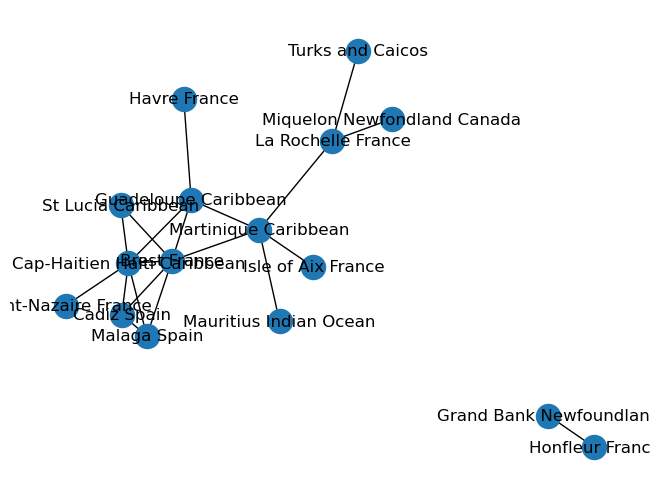

voyages.html


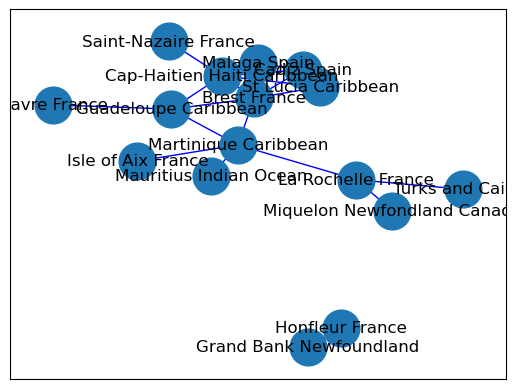

voyages.html


In [27]:
G = nx.from_pandas_edgelist(Updated_France_sorted_ship_voyages, 'VoyageFrom', 'VoyageTo')

nx.draw(G, with_labels=True)
plt.show()

net = Network(notebook=True)
net.from_nx(G)
net.show('voyages.html')

pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='blue')
nx.draw_networkx_labels(G, pos)
plt.show()


for node in G.nodes:
    net.add_node(node, title=node)

for edge in G.edges:
    net.add_edge(edge[0], edge[1])

net.show('voyages.html')